# Remote Sensing in Python
*Developed by Stef Lhermitte*

## Installation before starting

In this notebook we will learn how to download and visualise remote sensing data from various remote sensing sensors using the Sentinelhub package that is the python interface to the [Sentinel Playground](https://apps.sentinel-hub.com/sentinel-playground/). Therefore, you will build upon last week's mapping environment in Python and add various remote sensing data to it.

Before starting this notebook, you will need to install the sentinelhub and rasterio in your jupyter/conda environment. To install these packages you need to follow the following steps:

1. Activate the conda environment that you installed last week (i.e. `ox` environment from last week's example, bbut could also be another name). 
  * For windows you should first launch your conda prompt. If you don't know how to launch the conda prompt in Windows check [here](https://docs.anaconda.com/anaconda/install/verify-install/#conda). Once the conda prompt is launched, you should run `conda activate ox` in your conda prompt.
  * For Mac you should open your terminal (Spotlight Search -> Terminal) and the you can directly run `conda activate ox` in your conda prompt.
2. Install sentinelhub by running `pip install sentinelhub` in your conda prompt.
3. Install rasterio by running `conda install -c conda-forge rasterio`  in your conda prompt.
3. Launch the anaconda navigator and select the `ox` environment (see last week's example).
4. Start a jupyter notebook and open the current notebook.

## Download data from Sentinelhub.

In this notebook we show how to use WMS and WCS services provided by [Sentinel Hub](https://www.sentinel-hub.com/develop/documentation/api/ogc_api) to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data.

We start with examples using Sentinel-2 L1C data (Top-Of-Atmosphere reflectance) and then show how to also obtain Sentinel-2 L2A (Bottom-Of-Atmosphere reflectance), Landsat 8, MODIS and DEM data.

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, create one at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

In [38]:
# INSTANCE_ID = 'b0eec84c-9a8b-4186-8bd1-b79f90329fab'
INSTANCE_ID = 'f41f246d-4c06-418b-9127-82b3ca01606b'

#### Imports 
First, we import the necessary packages for this notebook.

In [39]:
# %reload_ext autoreload
# %autoreload 2

In [40]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import os
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox
from sentinelhub import CustomUrlParam
%matplotlib inline

#### Setting area of interest

Them we define a region of interest, which is Delft in our example. Therefore, we have to set up a bounding box with the region coordinates (i.e. longitude and latitude coordinates of upper left and lower right corners).

In [41]:
bbox_epsg4326 = [4.36, 52.01, 4.39, 51.98]

All requests require bounding box to be given as an instance of `sentinelhub.common.BBox` with corresponding Coordinate Reference System (`sentinelhub.common.CRS`). 

In [42]:
?CRS

In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.common.CRS`, but it could also be coordinates in WebMercator (i.e., `POP_WEB` ) and constants in form `UTM_<zone><direction>`.

In [43]:
CRS.POP_WEB

<CRS.POP_WEB: '3857'>

In [44]:
CRS.UTM_31N

<CRS.UTM_31N: '32631'>

In [45]:
delft_bbox = BBox(bbox=bbox_epsg4326,crs=CRS.WGS84)

If you want to determine bounding boxes yourself you can always use [geojson.io](www.geojson.io) to determine the coordinates>

### WMS request 

After setting up an area of interest, we can start querying and downloading the available data from SentinelHub.

We need to specify the following arguments in the initialization of a `WmsRequest`:

 * `layer` - set it to `'TRUE-COLOR-S2-L1C'`  In case you are not using a configuration based on **Python scripts template** you will now have to create a layer named `TRUE-COLOR-S2-L1C` yourself. In [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/) go to your configuration, add new layer which will use Sentinel-2 L1C data source and predefined product `TRUE COLOR, RGB Visualization` for `Data processing` parameter.
 * `bbox` - see above
 * `time` - time or time range for which to return the results, in ISO8601 format (year-month-date, for example: `2016-01-01`, or year-month-dateThours:minuts:seconds format, i.e. `2016-01-01T16:31:21`). When a single time is specified the request will return data for that specific date, if it exists. If a time range is specified the result is a list of all scenes between the specified dates conforming to the cloud coverage criteria. Most recent acquisition being first in the list. For the latest acquisition use `'latest'`. Examples: `'latest'`, `'2016-01-01'`, or `('2016-01-01', ' 2016-01-31')`
 * `width` and `height` - width and height of a returned image
     * we'll set them to 512 and 856, respectively
     * we could only set one of the two parameters and the other one would be set automatically in a way that image would best fit bounding box ratio 
 * `data_folder` - location of the directory where the fetched data will be saved
 * `image_format` - the data type that will be downloaded. We opt here for 32bit floating numbers in Geotiff data format `MimeType.TIFF_d32f`, but it could also be the default PNG `constants.MimeType.PNG`.
 * `maxcc` - maximum accepted cloud coverage of an image. Float between 0.0 and 1.0. Default is ``1.0``
 * `instance_id` - see above
 
All of the above arguments are obligatory and have to be set for all `WmsRequest`.

In [46]:
?WmsRequest

In [47]:
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=delft_bbox,
                                    time='2019-08-24', 
                                    width=1025,
                                    data_folder='test_dir',
                                    instance_id=INSTANCE_ID)

Subsequently, we can download the data

In [48]:
wms_true_color_img = wms_true_color_request.get_data(save_data=True)

Method `get_data()` will always return a list images in form of numpy arrays.

In [49]:
print('Returned data is of type ',type(wms_true_color_img),'and length',len(wms_true_color_img))

Returned data is of type  <class 'list'> and length 1


In [50]:
print('A single element in the list is of type',type(wms_true_color_img[-1]),'with shape',wms_true_color_img[-1].shape)

A single element in the list is of type <class 'numpy.ndarray'> with shape (1733, 1025, 3)


#### Date range

For a date range the query would look like

In [51]:
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=delft_bbox,
                                    time=('2019-08-01','2019-08-30'),
                                    width=1025,
                                    data_folder='test_dir',
                                    instance_id=INSTANCE_ID)

In [52]:
wms_true_color_img = wms_true_color_request.get_data(save_data=True)

And the resulting data would look like:

In [53]:
print('Returned data is of type ',type(wms_true_color_img),'and length',len(wms_true_color_img))

Returned data is of type  <class 'list'> and length 6


Note that as the length is larger than 1, we now get multiple images as a result. We can now access the individual images via simple list indexing. E.g. `wms_true_color_img[0]` returns the first image, `wms_true_color_img[2]` the second, `wms_true_color_img[-1]` the last etc.

Simultaneously, we can request the corresponding dates which returns a list of datetime elements.

In [54]:
wms_true_color_dates = wms_true_color_request.get_dates()
wms_true_color_dates

[datetime.datetime(2019, 8, 4, 10, 56, 45),
 datetime.datetime(2019, 8, 9, 10, 56, 48),
 datetime.datetime(2019, 8, 14, 10, 56, 44),
 datetime.datetime(2019, 8, 19, 10, 56, 47),
 datetime.datetime(2019, 8, 24, 10, 56, 43),
 datetime.datetime(2019, 8, 29, 10, 56, 45)]

#### Cloud cover limitations
The WMS request also allow to put a cloud cover constraint by using the `maxcc` - maximum accepted cloud coverage of an image.

In [55]:
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=delft_bbox,
                                    time=('2019-08-01','2019-08-30'),
                                    width=1025,
                                    data_folder='test_dir',
                                    maxcc=0.2,
                                    instance_id=INSTANCE_ID)

In [56]:
wms_true_color_dates = wms_true_color_request.get_dates()
wms_true_color_dates

[datetime.datetime(2019, 8, 19, 10, 56, 47),
 datetime.datetime(2019, 8, 24, 10, 56, 43)]

And you can see that by limiting the cloud cover we get less images.

#### WCS vs WMS request

With `WmsRequest` we use the Sentinel Hub WMS (Web Map Service) GetMap request, where the user specifies the desired image size instead of its resolution. Thereofore, it is required to specify at least one of `width` and `height` parameters in pixels and the request will adapt the resolution of the pixels to fit within the bounding box. 

With `WcsRequest` we use Sentinel Hub WCS (Web Coverage Service) GetCoverage request, similar to the WMS service. The
only difference is that in the case od WCS request the user specifies the desire resolution of the image instead of its size.
* `resx` : resolution in x (resolution of a column) given in meters in the format (examples `'10m'`, `'20m'`, ...). Default is `'10m'`, which is the best native resolution of some Sentinel-2 bands.
* `resy`: resolution in y (resolution of a row) given in meters in the format (examples `'10m'`, `'20m'`, ...). Default is `'10m'`, which is the best native resolution of some Sentinel-2 bands.

In [57]:
?WcsRequest

In [58]:
wms_true_color_request = WcsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=delft_bbox,
                                    time=('2019-08-01','2019-08-30'),
                                    resx='10m',
                                    resy='10m',
                                    data_folder='test_dir',
                                    instance_id=INSTANCE_ID)

In [59]:
wms_true_color_img = wms_true_color_request.get_data(save_data=True)

#### Download raw band values  

We can also download the original Sentinel-2 data using a custom script:
```Javascript
return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
```

Here we have to set the `image_format` argument to `sentinelhub.constants.MimeType.TIFF_d32f`, since we can't pack all Sentinel-2's 13 bands into a png image. This format will also ensure that we will get image reflectance in 32-bit float values.

In [60]:
my_evalscript = '''
return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
'''

In [61]:
wms_bands_request = WcsRequest(layer='TRUE-COLOR-S2-L1C',
                                bbox=delft_bbox,
                                time=('2019-08-01','2019-08-30'),
                                resx='10m',
                                resy='10m',
                                data_folder='test_dir',
                                image_format=MimeType.TIFF_d32f,
                                instance_id=INSTANCE_ID,
                                maxcc = 0.1,
                                custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript})

In [62]:
wms_bands_img = wms_bands_request.get_data(save_data=True)

In [63]:
wms_bands_dates = wms_bands_request.get_dates()
wms_bands_dates

[datetime.datetime(2019, 8, 24, 10, 56, 43)]

We now can see that the shape of the returned images changed from 3 to 13 bands.

In [64]:
print('A single element in the list is of type',type(wms_bands_img[-1]),'with shape',wms_bands_img[-1].shape)

A single element in the list is of type <class 'numpy.ndarray'> with shape (334, 205, 13)


### Reading/accessing the data downloaded

After downloading the data, we can start analyzing and plotting the data. This can be done in two ways:

* Directly from the `.get_data()` result
* Indirectly by reading the downloaded data from the `data_folder`

Let's start with the direct approach. For example

In [65]:
date0_img = wms_bands_img[0]
date0_img

array([[[0.1444, 0.1087, 0.0931, ..., 0.0015, 0.1787, 0.147 ],
        [0.1444, 0.1059, 0.0898, ..., 0.0015, 0.1787, 0.147 ],
        [0.1444, 0.1093, 0.0872, ..., 0.0015, 0.1835, 0.1617],
        ...,
        [0.1314, 0.1085, 0.1068, ..., 0.0012, 0.2173, 0.173 ],
        [0.1592, 0.1017, 0.0953, ..., 0.0012, 0.1626, 0.1138],
        [0.1592, 0.0971, 0.0864, ..., 0.0012, 0.1626, 0.1138]],

       [[0.1444, 0.1056, 0.0912, ..., 0.0015, 0.1787, 0.147 ],
        [0.1444, 0.104 , 0.0846, ..., 0.0015, 0.1787, 0.147 ],
        [0.1444, 0.1115, 0.0951, ..., 0.0015, 0.1835, 0.1617],
        ...,
        [0.1314, 0.097 , 0.0822, ..., 0.0012, 0.2173, 0.173 ],
        [0.1592, 0.0979, 0.082 , ..., 0.0012, 0.1626, 0.1138],
        [0.1592, 0.0975, 0.0808, ..., 0.0012, 0.1626, 0.1138]],

       [[0.1462, 0.1129, 0.0951, ..., 0.0013, 0.1961, 0.1704],
        [0.1462, 0.1225, 0.1025, ..., 0.0013, 0.1961, 0.1704],
        [0.1462, 0.1264, 0.1095, ..., 0.0013, 0.1688, 0.1414],
        ...,
        [0.1

In [66]:
date0_img.shape

(334, 205, 13)

In [67]:
date0_dat = wms_bands_dates[0]
date0_dat

datetime.datetime(2019, 8, 24, 10, 56, 43)

Or alternatively, we can read the data indirectly via the rasterio package.

Therefore, we first need to locate the downloaded files. This can be done using the `os.listdir` which returns a list containing the names of the files in the download directory.

In [68]:
os.listdir(wms_true_color_request.data_folder)

['wms_TRUE-COLOR-S2-L1C_EPSG4326_4.36_51.98_4.39_52.01_2019-08-19T10-56-47_1025X1733.png',
 'wcs_BANDS-S1-EW-SH_EPSG4326_4.36_51.98_4.39_52.01_2019-07-26T05-50-15_40mX40m_EvalScript_return[HH,VV]_tiff_depth=32f.tiff',
 'wcs_TRUE-COLOR-S2-L1C_EPSG4326_4.36_51.98_4.39_52.01_2019-08-24T10-56-43_10mX10m_EvalScript_return[B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]_tiff_depth=32f.tiff',
 'wcs_BANDS-MODIS_EPSG4326_4.36_51.98_4.39_52.01_2019-07-18T12-00-00_10mX10m_EvalScript_return[B01,B02,B03,B04,B05,B06,B07]_tiff_depth=32f.tiff',
 'wcs_BANDS-MODIS_EPSG4326_4.36_51.98_4.39_52.01_2019-07-30T12-00-00_10mX10m_EvalScript_return[B01,B02,B03,B04,B05,B06,B07]_tiff_depth=32f.tiff',
 'wcs_BANDS-MODIS_EPSG4326_4.36_51.98_4.39_52.01_2019-07-24T12-00-00_10mX10m_EvalScript_return[B01,B02,B03,B04,B05,B06,B07]_tiff_depth=32f.tiff',
 'wcs_BANDS-MODIS_EPSG4326_4.36_51.98_4.39_52.01_2019-07-22T12-00-00_10mX10m_EvalScript_return[B01,B02,B03,B04,B05,B06,B07]_tiff_depth=32f.tiff',
 'wcs_BANDS-S1-IW_EPSG

And then open the required file:

In [69]:
wms_true_color_request.data_folder+'/'+os.listdir(wms_true_color_request.data_folder)[1]

'test_dir/wcs_BANDS-S1-EW-SH_EPSG4326_4.36_51.98_4.39_52.01_2019-07-26T05-50-15_40mX40m_EvalScript_return[HH,VV]_tiff_depth=32f.tiff'

In [70]:
imr = rasterio.open(wms_true_color_request.data_folder+'/'+os.listdir(wms_true_color_request.data_folder)[1])
imo  = imr.read()

In [71]:
imo.shape

(2, 83, 51)

The organisation of the data is slightly different in the indirect and directs approach as you can see from the `shape` functions. In the indirect `rasterio` approach the data are (nbands,nrows,ncols) arrays, whereas in the direct approach it are (nrows,ncols,nbands) arrays.

### Analyzing plotting the data
Once the data are downloaded and opened, we can start analyzing them. 

For example, we can make histograms of their reflectance values.

Text(0,0.5,'Probability density by counts')

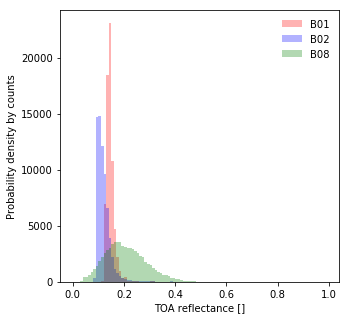

In [72]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(date0_img[:,:,0].flatten(),bins=np.arange(0, 1, 0.01),color='red',alpha=0.3,label='B01')
ax.hist(date0_img[:,:,1].flatten(),bins=np.arange(0, 1, 0.01),color='blue',alpha=0.3,label='B02')
ax.hist(date0_img[:,:,7].flatten(),bins=np.arange(0, 1, 0.01),color='green',alpha=0.3,label='B08')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('TOA reflectance []')
ax.set_ylabel('Probability density by counts')
# ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

Or plotting them in a map. For example, for plotting one band:

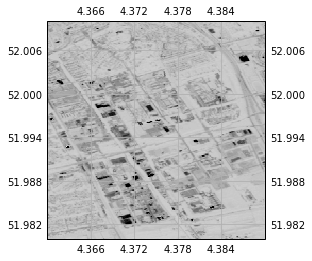

In [73]:
plt.figure()
crs=ccrs.PlateCarree()
ax = plt.axes(projection=crs)
img_extent = [4.36,4.39,51.98,52.01]
ax.set_extent(img_extent)
ax.imshow(date0_img[:,:,1],vmin=0,vmax=0.3, extent=img_extent, origin='upper',cmap='Greys')
ax.gridlines(draw_labels=True)

Or by plotting the true color image. Note that by addding a constant and with a constant we can increase the brightness/contrast of the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


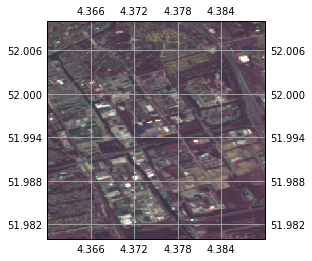

In [74]:
true_color = date0_img[:,:,np.arange(4,1,-1)]*2.5+0.1
plt.figure()
crs=ccrs.PlateCarree()
ax = plt.axes(projection=crs)
ax.set_extent([4.36,4.39,51.98,52.01])
ax.imshow(true_color,extent=img_extent, origin='upper')
ax.gridlines(draw_labels=True)

### Data Sources

With the SentinelHub package, we can also download different data types. Default data source is Sentinel-2 L1C (i.e. Top-Of-Atmosphere reflectance) however currently the following is supported:

In [75]:
from sentinelhub import DataSource

for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8


In order to obtain data from any of these data sources with `WmsRequest` or `WcsRequest` we have to do the following: 

- Use  a configuration based on **Python scripts template** or create a new layer in [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/) that is defined to use desired satellite data source. Set the `layer` parameter of `WmsRequest` or `WcsRequest` to the name of this newly created layer.
- Set `data_source` parameter of `WmsRequest` or `WcsRequest` to the same data source (using one of the objects from the list above).

#### Example: Sentinel-2 L2A

When you have a layer named `TRUE-COLOR-S2-L2A` in your configuration let's try to obtain some level 2A images, which are atmopsherically corrected reflectance images. Unfortunately L2A images are being processed only for some regions 

In [76]:
my_evalscript = '''
return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12]
'''

In [77]:
wms_bands_request = WcsRequest(data_source=DataSource.SENTINEL2_L2A,
                               layer='TRUE-COLOR-S2-L2A',
                                bbox=delft_bbox,
                                time=('2019-08-01','2019-08-30'),
                                resx='10m',
                                resy='10m',
                                data_folder='test_dir',
                                image_format=MimeType.TIFF_d32f,
                                instance_id=INSTANCE_ID,
                                maxcc = 0.1,
                                custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript})

In [78]:
L2A_wms_bands_img = wms_bands_request.get_data(save_data=True)

In [79]:
L2A_wms_bands_dates = wms_bands_request.get_dates()
wms_bands_dates

[datetime.datetime(2019, 8, 24, 10, 56, 43)]

Now we can start to compare the reflectance values before/after atmospheric correction

Text(0,0.5,'Probability density by counts')

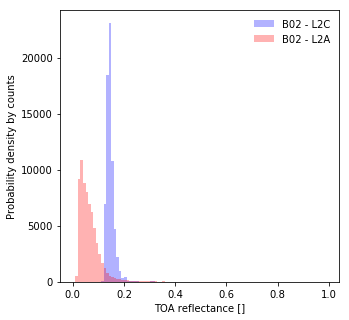

In [80]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(date0_img[:,:,0].flatten(),bins=np.arange(0, 1, 0.01),color='blue',alpha=0.3,label='B02 - L2C')
ax.hist(L2A_wms_bands_img[0][:,:,1].flatten(),bins=np.arange(0, 1, 0.01),color='red',alpha=0.3,label='B02 - L2A')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('TOA reflectance []')
ax.set_ylabel('Probability density by counts')

#### Example: MODIS

Alternatively, we can try to add MODIS coarse resolution images

In [81]:
my_evalscript = '''
return [B01,B02,B03,B04,B05,B06,B07]
'''

In [82]:
wms_bands_request = WcsRequest(data_source=DataSource.MODIS,
                               layer='BANDS-MODIS',
                                bbox=delft_bbox,
                                time=('2019-07-01','2019-08-30'),
                                data_folder='test_dir',
                                image_format=MimeType.TIFF_d32f,
                                instance_id=INSTANCE_ID,
                                custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript})

In [83]:
MOD_wms_bands_img = wms_bands_request.get_data(save_data=True)

In [84]:
MOD_wms_bands_dates = wms_bands_request.get_dates()
MOD_wms_bands_dates

[datetime.datetime(2019, 7, 1, 12, 0),
 datetime.datetime(2019, 7, 2, 12, 0),
 datetime.datetime(2019, 7, 3, 12, 0),
 datetime.datetime(2019, 7, 5, 12, 0),
 datetime.datetime(2019, 7, 6, 12, 0),
 datetime.datetime(2019, 7, 7, 12, 0),
 datetime.datetime(2019, 7, 8, 12, 0),
 datetime.datetime(2019, 7, 9, 12, 0),
 datetime.datetime(2019, 7, 10, 12, 0),
 datetime.datetime(2019, 7, 11, 12, 0),
 datetime.datetime(2019, 7, 12, 12, 0),
 datetime.datetime(2019, 7, 13, 12, 0),
 datetime.datetime(2019, 7, 14, 12, 0),
 datetime.datetime(2019, 7, 15, 12, 0),
 datetime.datetime(2019, 7, 16, 12, 0),
 datetime.datetime(2019, 7, 17, 12, 0),
 datetime.datetime(2019, 7, 18, 12, 0),
 datetime.datetime(2019, 7, 19, 12, 0),
 datetime.datetime(2019, 7, 20, 12, 0),
 datetime.datetime(2019, 7, 21, 12, 0),
 datetime.datetime(2019, 7, 22, 12, 0),
 datetime.datetime(2019, 7, 23, 12, 0),
 datetime.datetime(2019, 7, 24, 12, 0),
 datetime.datetime(2019, 7, 25, 12, 0),
 datetime.datetime(2019, 7, 26, 12, 0),
 datetim

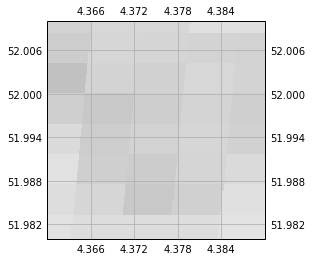

In [85]:
plt.figure()
crs=ccrs.PlateCarree()
ax = plt.axes(projection=crs)
ax.set_extent([4.36,4.39,51.98,52.01])
ax.imshow(MOD_wms_bands_img[0][:,:,0],vmin=0,vmax=0.3, extent=img_extent, origin='upper',cmap='Greys')
ax.gridlines(draw_labels=True)

#### Example: Sentinel-1

Alternatively, we can try to add Sentinel SAR radar images.

In [86]:
my_evalscript = '''
return [VV]
'''

In [87]:
wms_bands_request = WcsRequest(data_source=DataSource.SENTINEL1_IW,
                               layer='BANDS-S1-IW',
                                bbox=delft_bbox,
                                time=('2019-08-20','2019-08-30'),
                                data_folder='test_dir',
                                resx='10m',
                                resy='10m',
                                image_format=MimeType.TIFF_d32f,
                                instance_id=INSTANCE_ID,
                                custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript})

In [88]:
S1_wms_bands_img = wms_bands_request.get_data(save_data=True)
S1_wms_bands_img

[array([[0.1437, 0.2074, 0.3546, ..., 0.124 , 0.3147, 0.3757],
        [0.161 , 0.3665, 0.6706, ..., 0.0629, 0.0998, 0.2123],
        [0.2415, 0.2415, 0.9923, ..., 0.0935, 0.0671, 0.1736],
        ...,
        [0.1243, 0.1118, 0.1052, ..., 0.086 , 0.0669, 0.0587],
        [0.1543, 0.1419, 0.0561, ..., 0.11  , 0.0767, 0.068 ],
        [0.1543, 0.2276, 0.076 , ..., 0.0848, 0.0813, 0.1008]],
       dtype=float32),
 array([[0.1276, 0.1914, 0.3129, ..., 0.0899, 0.286 , 0.1855],
        [0.1109, 0.2376, 0.514 , ..., 0.0652, 0.0828, 0.1855],
        [0.1378, 0.6473, 1.2879, ..., 0.1299, 0.0533, 0.1241],
        ...,
        [0.1283, 0.1241, 0.0923, ..., 0.0898, 0.06  , 0.0513],
        [0.1327, 0.1432, 0.1401, ..., 0.0984, 0.0747, 0.0758],
        [0.0985, 0.1386, 0.1871, ..., 0.0714, 0.0886, 0.101 ]],
       dtype=float32),
 array([[0.3188, 0.453 , 0.361 , ..., 0.1529, 0.1934, 0.1294],
        [0.4507, 0.8222, 0.5919, ..., 0.0611, 0.1078, 0.1319],
        [0.6295, 1.0474, 0.6025, ..., 0.1159

In [89]:
S1_wms_bands_dates = wms_bands_request.get_dates()
S1_wms_bands_dates

[datetime.datetime(2019, 8, 21, 17, 32, 24),
 datetime.datetime(2019, 8, 21, 17, 32, 42),
 datetime.datetime(2019, 8, 22, 17, 25, 8),
 datetime.datetime(2019, 8, 24, 5, 58, 26),
 datetime.datetime(2019, 8, 24, 5, 58, 35),
 datetime.datetime(2019, 8, 25, 5, 49, 27),
 datetime.datetime(2019, 8, 25, 5, 49, 37),
 datetime.datetime(2019, 8, 27, 17, 33, 15),
 datetime.datetime(2019, 8, 27, 17, 33, 24),
 datetime.datetime(2019, 8, 28, 17, 24, 19),
 datetime.datetime(2019, 8, 30, 5, 57, 30),
 datetime.datetime(2019, 8, 30, 5, 57, 54),
 datetime.datetime(2019, 8, 30, 5, 57, 55)]

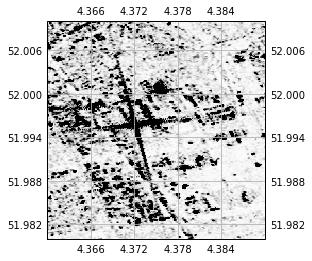

In [90]:
plt.figure()
crs=ccrs.PlateCarree()
ax = plt.axes(projection=crs)
ax.set_extent([4.36,4.39,51.98,52.01])
ax.imshow(S1_wms_bands_img[0][:,:],vmin=0,vmax=1, extent=img_extent, origin='upper',cmap='Greys')
ax.gridlines(draw_labels=True)

# Exercise

1.   Add Sentinel-2 top-of-atmosphere data to your map environment of Remote Sensing Notebook 1
  * Set-up your own mapping environment over your own region of interest (See notebook 1)
  * Add a (relatively) cloud free Sentinel top-of-atmosphere true color image to the map
2.   Download for your region of interest a a) Sentinel-2 top-of-atmosphere reflectance image, b) Sentinel-2 bottom-of-atmosphere reflectance image and compare the reflectance values for the Blue, Green, Red and NIR bands for both images. Make a histogram + map to compare both images and use a Markdown cell to explain the differences you observe between top and bottom of-atmosphere reflectance.
3.   Add a MODIS true color reflectance image to your map environment of Remote Sensing Notebook 1 and compare that with the image of Exercise 1. Use a Markdown cell to explain the differences you observe between MODIS and Sentinel-2.
4.   Add a Sentinel-1 SAR backscatter image to  your map environment of Remote Sensing Notebook 1 and compare that with the image of Exercise 1. Use a Markdown cell to explain the differences you observe between Sentinel-1 and Sentinel-2.